# Анализ результатов A/B-тестирования (биддинг)

Недавно компания представила новый тип торгов (биддинг) — «средняя ставка» — в качестве альтернативы существующему типу торгов, называемому «максимальная ставка». Один из клиентов решил протестировать эту новую функцию и хочет провести A/B-тестирование, чтобы понять, приносит ли средняя ставка больше конверсий, чем максимальная.

A/B-тестирование продолжалось месяц, и клиент теперь ожидает анализ и результаты этого A/B-тестирования.

Задача: 

- Ознакомиться с данным
- Провести анализ полученных результатов в контрольной и тестовой группах
- Оценить корректность проведения теста
- Проанализировать результаты теста

## Описание данных

Даные представлены двумя таблицами:
- `control_group` - содержит данные контрольной группы
- `test_group` - содержит данные тестовой группы

Описание таблицы `control_group` и `test_group`:
- `Campaign Name` - название кампании
- `Date` - дата
- `Spend [USD]` - потраченные деньги
- `Reach` - Охват (количество уникальных пользователей, увидевших рекламу)
- `# of Website Clicks` - количество переходов на сайт. Переменная, связанная с переходом пользователя по ссылке на сайт в рекламе
- `# of Searches` - количество поисковых запросов. Переменная, связанная с выполнением пользователем поиска на сайте
- `# of View Content` - количество просмотров контента. Переменная, связанная с просмотром пользователем информации о товаре
- `# of Add to Cart` - количество добавлений в корзину. Переменная, связанная с добавлением пользователем товара в корзину
- `# of Purchase `- количество покупок. Переменная, связанная с покупкой товара пользователем

Пользователи в таблицах не пересекаются

## 1. Загрузка данных и знакомство с ними

Начнём с загрузки библиотек и датасета `control_group`. Будем использовать pandas и библиотеки визуализации данных matplotlib и seaborn. Данные датасета сохраним в переменной `control_group_df`.  

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil
from scipy.stats import ttest_ind
from scipy import stats 
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Выгружаем данные в переменную
control_group_df = pd.read_csv('control_group.csv')

In [3]:
# Выводим первые строки датафрейма на экран
control_group_df.head()

,Campaign Name,Date,Spend [USD],Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Выводим информацию о датафрейме
control_group_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        30 non-null     object 
 1   Date                 30 non-null     object 
 2   Spend [USD]          30 non-null     int64  
 3   Reach                29 non-null     float64
 4   # of Website Clicks  29 non-null     float64
 5   # of Searches        29 non-null     float64
 6   # of View Content    29 non-null     float64
 7   # of Add to Cart     29 non-null     float64
 8   # of Purchase        29 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.2+ KB


In [5]:
# Проверим количество пропусков
tmp = control_group_df.copy()            # Делаем копию текущего датасета
missing_stats = pd.DataFrame({'Кол-во пропусков': tmp.isnull().sum(),'Доля пропусков': tmp.isnull().mean().round(4)})
missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
missing_stats.style.background_gradient(cmap='coolwarm') if not missing_stats.empty else "Пропусков в данных нет"

,Кол-во пропусков,Доля пропусков
Reach,1,0.033300
# of Website Clicks,1,0.033300
# of Searches,1,0.033300
# of View Content,1,0.033300
# of Add to Cart,1,0.033300
# of Purchase,1,0.033300


In [6]:
# Проверка наличия явных дубликатов
duplicated_rows = control_group_df.duplicated().sum()

print(f"Количество явных дубликатов: {duplicated_rows}")

Количество явных дубликатов: 0


In [7]:
# Проверим дубликаты по столбцу Date:
control_group_df[control_group_df.duplicated(subset=['Date'], keep=False)]

,Campaign Name,Date,Spend [USD],Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase


Датасет `control_group.csv` содержит 9 столбцов и 30 строк по количеству дней проводимого теста, в которых представлена информация о ежедневном количестве и сумме покупок (а также по этапам всей воронки) после увиденной рекламы пользователей контрольной группы (которые не уведомлялись о новом типе торргов).

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов имеют однообразный вид, но требуют переименования в соответствии со стандартом snake case и необходимо удалить из наименований столбцов символы "# of".
- Данные имеют тип данных `object` и `float64` и `int`. Корректны следующие типов данных для столбцов (требуют переименования):
     - `Date` - тип `datetime64`
     - `Spend [USD]` - тип `float64`
     - остальные столбцы (за исключением названия кампании) -  тип `int`, т.к. не могут иметь дробных частей
- Пропуски содержатся во всех столбцах кроме даты, названия кампании и затраченных денег - по одному значению, что составляет 3%. Пропуски можно заполнить медианными значениями.	 
- Явные и неявные (по столбцу Data) дубликаты строк отсутствуют.
- Значения в столбцах соответствуют описанию.

In [8]:
# Приведем все столбцы к стилю snake case 
def to_snake_case(name):
    name = name.strip()                          # Удаляем пробелы по краям
    name = name.replace("# of ", "")             # Удаляем "# of"
    name = name.replace("[", "")                 # Удаляем квадратные скобки
    name = name.replace("]", "")                 # Удаляем квадратные скобки
    name = " ".join(name.split())                # Удаляем повторяющиеся пробелы внутри
    name = name.lower()                          # Приводим к нижнему регистру
    name = name.replace(" ", "_")                # Заменяем пробелы на нижние подчеркивания
    return name

# Преобразование всех названий столбцов
control_group_df.columns = [to_snake_case(col) for col in control_group_df.columns]

# Проверка наименований столбцов после преобразования
control_group_df.columns

Index(['campaign_name', 'date', 'spend_usd', 'reach', 'website_clicks',
       'searches', 'view_content', 'add_to_cart', 'purchase'],
      dtype='object')

In [9]:
# Заполняем пропуски

# Создаем список колонок с пропусками
null_columns = [
    'reach',
    'website_clicks',
    'searches',
    'view_content',
    'add_to_cart',
    'purchase'
]

control_group_df[null_columns] = control_group_df[null_columns].fillna(control_group_df[null_columns].median())

In [10]:
# Преобразуем типы данных
control_group_df['date'] = pd.to_datetime(control_group_df['date'], format="%d.%m.%Y", errors='raise')
control_group_df['spend_usd'] = control_group_df['spend_usd'].astype('float')

def convert_columns_to_int(df, columns):
    for col in columns:
        df[col] = df[col].astype('int')
    return df

control_group_df = convert_columns_to_int(
    control_group_df,
    ['reach', 'website_clicks', 'searches', 'view_content', 'add_to_cart', 'purchase'])

In [11]:
# Проверка датасета после преобразований
control_group_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   campaign_name   30 non-null     object        
 1   date            30 non-null     datetime64[ns]
 2   spend_usd       30 non-null     float64       
 3   reach           30 non-null     int64         
 4   website_clicks  30 non-null     int64         
 5   searches        30 non-null     int64         
 6   view_content    30 non-null     int64         
 7   add_to_cart     30 non-null     int64         
 8   purchase        30 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 2.2+ KB


In [12]:
# Выводим первые строки датафрейма на экран
control_group_df.head()

,campaign_name,date,spend_usd,reach,website_clicks,searches,view_content,add_to_cart,purchase
0,Control Campaign,2019-08-01,2280.0,56930,7016,2290,2159,1819,618
1,Control Campaign,2019-08-02,1757.0,102513,8110,2033,1841,1219,511
2,Control Campaign,2019-08-03,2343.0,110862,6508,1737,1549,1134,372
3,Control Campaign,2019-08-04,1940.0,61235,3065,1042,982,1183,340
4,Control Campaign,2019-08-05,1835.0,91579,5224,2390,1984,1339,501


Познакомимся аналогично с данными датасета `test_group`.

In [13]:
# Выгружаем данные в переменную
test_group_df = pd.read_csv('test_group.csv')

In [14]:
# Выводим первые строки датафрейма на экран
test_group_df.head()

,Campaign Name,Date,Spend [USD],Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,95138,5863,2106,858,956,768


In [15]:
# Выводим информацию о датафрейме
test_group_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 non-null     object
 1   Date                 30 non-null     object
 2   Spend [USD]          30 non-null     int64 
 3   Reach                30 non-null     int64 
 4   # of Website Clicks  30 non-null     int64 
 5   # of Searches        30 non-null     int64 
 6   # of View Content    30 non-null     int64 
 7   # of Add to Cart     30 non-null     int64 
 8   # of Purchase        30 non-null     int64 
dtypes: int64(7), object(2)
memory usage: 2.2+ KB


In [16]:
# Проверка наличия явных дубликатов
duplicated_rows = test_group_df.duplicated().sum()

print(f"Количество явных дубликатов: {duplicated_rows}")

Количество явных дубликатов: 0


In [17]:
# Проверим дубликаты по столбцу Date:
test_group_df[test_group_df.duplicated(subset=['Date'], keep=False)]

,Campaign Name,Date,Spend [USD],Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase


Датасет `test_group.csv` содержит 9 столбцов и 30 строк по количеству дней проводимого теста, в которых представлена информация о ежедневном количестве и сумме покупок (а также по этапам всей воронки) после увиденной рекламы пользователей тестовой группы (которые уведомлялись о новом типе торргов).

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов имеют однообразный вид, но требуют переименования в соответствии со стандартом snake case и необходимо удалить из наименований столбцов символы "# of".
- Данные имеют тип данных `object` и `int`. Корректны следующие типов данных для столбцов (требуют переименования):
     - `Date` - тип `datetime64`
     - `Spend [USD]` - тип `float64`
- Пропуски отсутсвуют.	 
- Явные и неявные (по столбцу Data) дубликаты строк отсутствуют.
- Значения в столбцах соответствуют описанию.

In [18]:
# Приведем все столбцы к стилю snake case 
def to_snake_case(name):
    name = name.strip()                          # Удаляем пробелы по краям
    name = name.replace("# of ", "")             # Удаляем "# of"
    name = name.replace("[", "")                 # Удаляем квадратные скобки
    name = name.replace("]", "")                 # Удаляем квадратные скобки
    name = " ".join(name.split())                # Удаляем повторяющиеся пробелы внутри
    name = name.lower()                          # Приводим к нижнему регистру
    name = name.replace(" ", "_")                # Заменяем пробелы на нижние подчеркивания
    return name

# Преобразование всех названий столбцов
test_group_df.columns = [to_snake_case(col) for col in test_group_df.columns]

# Проверка наименований столбцов после преобразования
test_group_df.columns

Index(['campaign_name', 'date', 'spend_usd', 'reach', 'website_clicks',
       'searches', 'view_content', 'add_to_cart', 'purchase'],
      dtype='object')

In [19]:
# Преобразуем типы данных
test_group_df['date'] = pd.to_datetime(test_group_df['date'], format="%d.%m.%Y", errors='raise')
test_group_df['spend_usd'] = test_group_df['spend_usd'].astype('float')

In [20]:
# Проверка датасета после преобразований
control_group_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   campaign_name   30 non-null     object        
 1   date            30 non-null     datetime64[ns]
 2   spend_usd       30 non-null     float64       
 3   reach           30 non-null     int64         
 4   website_clicks  30 non-null     int64         
 5   searches        30 non-null     int64         
 6   view_content    30 non-null     int64         
 7   add_to_cart     30 non-null     int64         
 8   purchase        30 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 2.2+ KB


In [21]:
# Выводим первые строки датафрейма на экран
test_group_df.head()

,campaign_name,date,spend_usd,reach,website_clicks,searches,view_content,add_to_cart,purchase
0,Test Campaign,2019-08-01,3008.0,35820,3038,1946,1069,894,255
1,Test Campaign,2019-08-02,2542.0,91236,4657,2359,1548,879,677
2,Test Campaign,2019-08-03,2365.0,45198,7885,2572,2367,1268,578
3,Test Campaign,2019-08-04,2710.0,25937,4216,2216,1437,566,340
4,Test Campaign,2019-08-05,2297.0,95138,5863,2106,858,956,768


In [22]:
# Объединим датасеты с игнорированием индексов (чтобы избежать дубликатов индексов)
combined_df = pd.concat([test_group_df, control_group_df], axis=0, ignore_index=True)

In [23]:
# Выводим информацию об итоговом датафрейме
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   campaign_name   60 non-null     object        
 1   date            60 non-null     datetime64[ns]
 2   spend_usd       60 non-null     float64       
 3   reach           60 non-null     int64         
 4   website_clicks  60 non-null     int64         
 5   searches        60 non-null     int64         
 6   view_content    60 non-null     int64         
 7   add_to_cart     60 non-null     int64         
 8   purchase        60 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 4.3+ KB


In [24]:
# Проверяем уникальные значения в наименовании компаний
combined_df["campaign_name"].sort_values().unique()

array(['Control Campaign', 'Test Campaign'], dtype=object)

<div style="border:solid Chocolate 2px; padding: 10px">
    
Датасеты `control_group.csv` и `test_group.csv` содержат по 9 столбцов и 30 строк по количеству дней проводимого теста, в которых представлена информация о ежедневном количестве и сумме покупок (а также по этапам всей воронки) после увиденной рекламы пользователей контрольной группы (которые НЕ уведомлялись о новом типе торгов) и тестовой группы (которые уведомлялись о новом типе торргов).

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов переименованы в соответствии со стандартом snake case, удалены лишние символы "# of".
- Типы данных предобразованы в соответствии со смыслом.
- Пропуски в датасете контрольной группы заполнены медианными значениями (по одному пропуску в столбцах), в датасете тестовой группы пропуски отсутствуют.	 
- Явные и неявные (по столбцу Data) дубликаты строк отсутствуют.
- Значения в столбцах соответствуют описанию.

Для анализа а/b теста датасеты были объединены, т.к. колонки одинаковые

## 2.Анализ полученных результатов тестовой и контрольной групп

Рассмотрим ежедневную динамику охвата и конверсии в продажу контрольной и тестовой групп

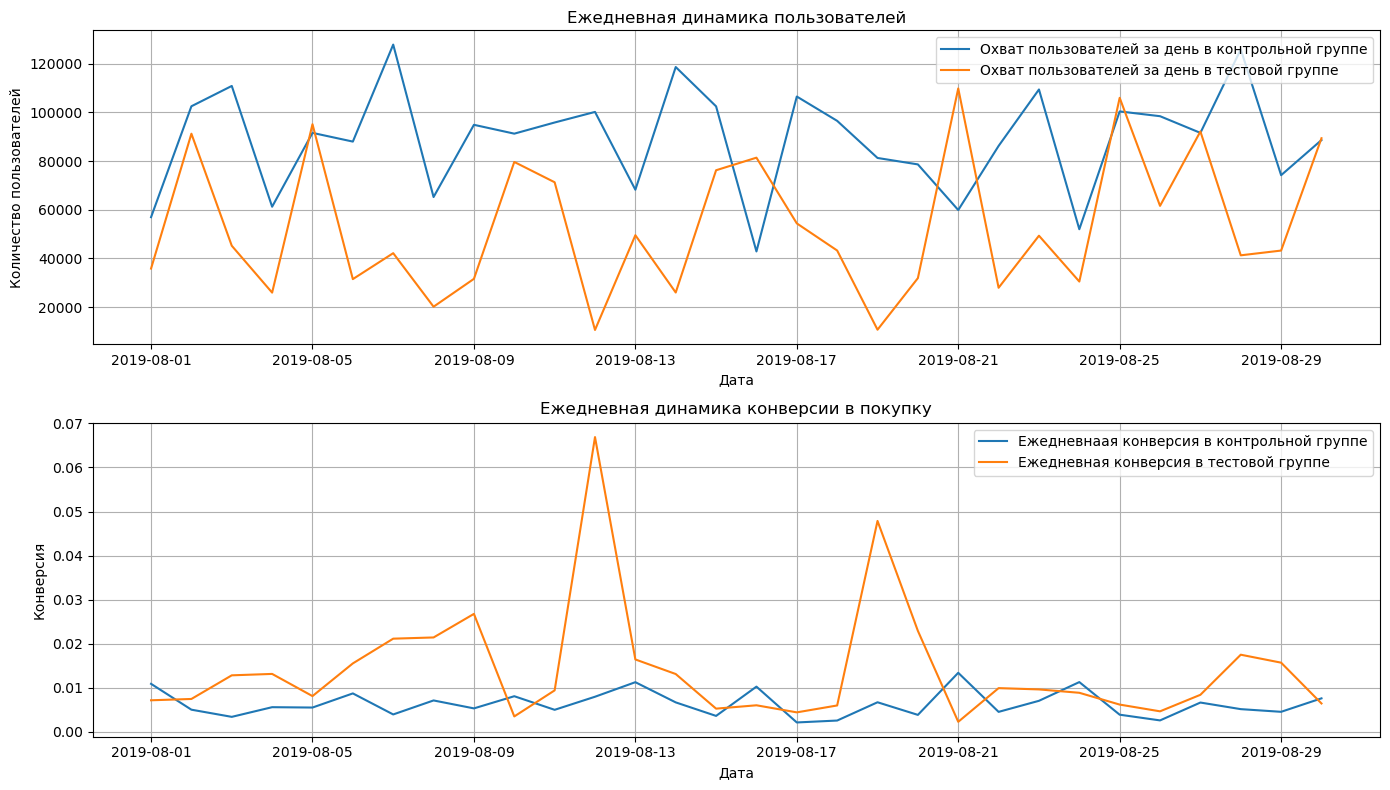

In [25]:
# Расчет доли покупок
control_group_df['daily_purchase_ratio'] = control_group_df['purchase'] / control_group_df['reach']
test_group_df['daily_purchase_ratio'] = test_group_df['purchase'] / test_group_df['reach']

# Стиль графиков
plt.figure(figsize=(14, 8))

# График 1: Ежедневные значения охвата (тестовой и контрольной групп)
plt.subplot(2, 1, 1)
plt.plot(control_group_df['date'], control_group_df['reach'], 
         label='Охват пользователей за день в контрольной группе')
plt.plot(test_group_df['date'], test_group_df['reach'], 
         label='Охват пользователей за день в тестовой группе')

plt.title('Ежедневная динамика пользователей')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')
plt.grid(True)

# График 2: Доля покупок (конверсия в покупку)

plt.subplot(2, 1, 2)
plt.plot(control_group_df['date'], control_group_df['daily_purchase_ratio'], 
         label='Ежедневнаая конверсия в контрольной группе')
plt.plot(test_group_df['date'], test_group_df['daily_purchase_ratio'], 
         label='Ежедневная конверсия в тестовой группе')

plt.title('Ежедневная динамика конверсии в покупку')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Сравним воронки в тестовой и контрольной группах

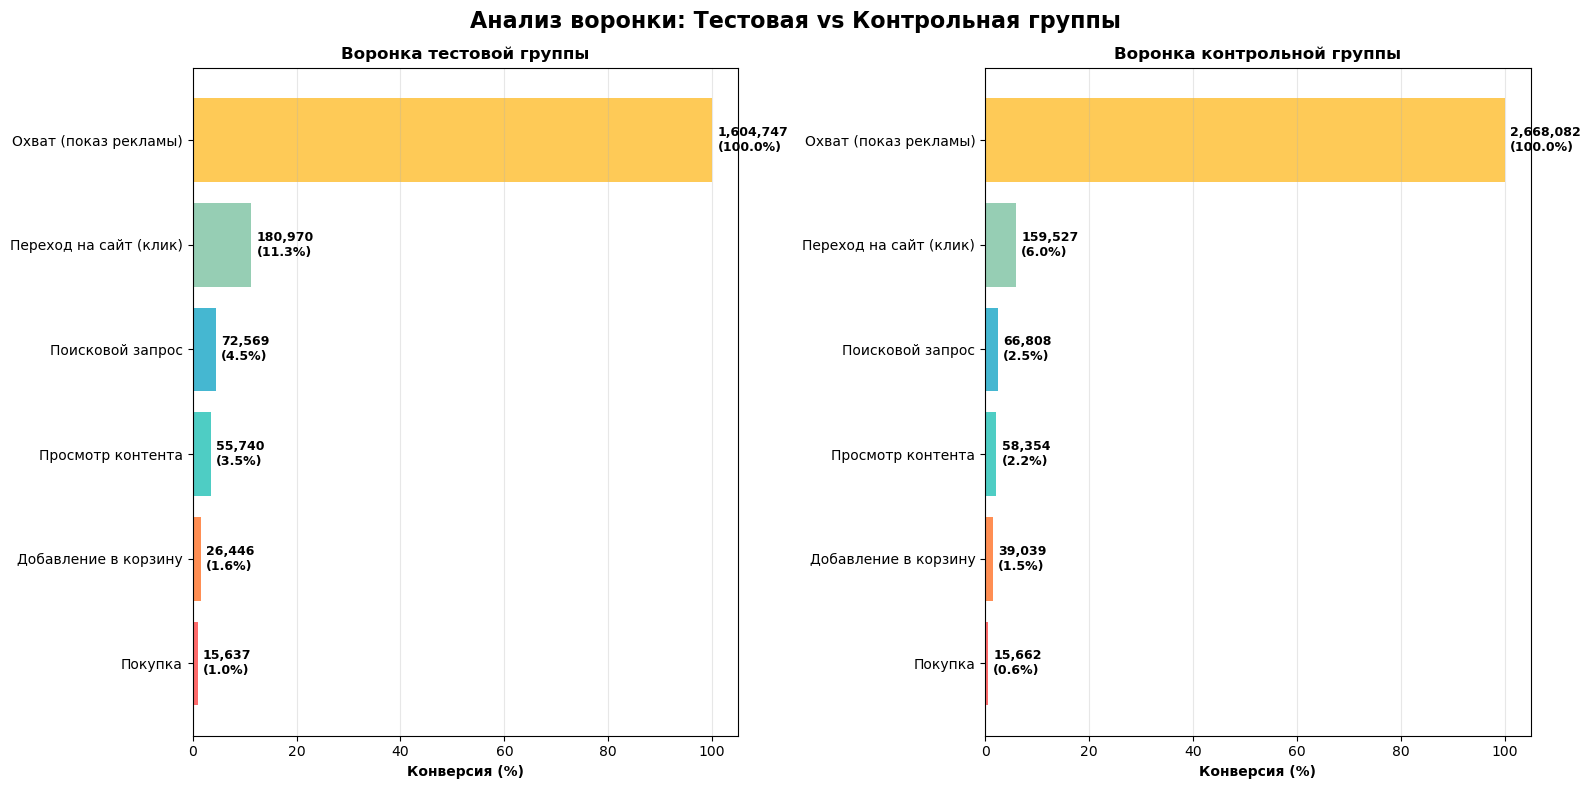

In [26]:
# Воронки для тестовой и контрольной групп

# Агрегируем данные по группам
funnel_data = combined_df.groupby('campaign_name').agg({
    'reach': 'sum',
    'website_clicks': 'sum',
    'searches': 'sum',
    'view_content': 'sum',
    'add_to_cart': 'sum',
    'purchase': 'sum'
}).reset_index()

# Создаем данные для воронки
funnel_stages = ['Охват (показ рекламы)', 'Переход на сайт (клик)', 'Поисковой запрос', 'Просмотр контента', 'Добавление в корзину', 'Покупка']
funnel_colors = ['#FF6B6B', '#FF8E53', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

# Создаем визуализацию
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Анализ воронки: Тестовая vs Контрольная группы', fontsize=16, fontweight='bold')

# Воронка для test группы
test_values = funnel_data[funnel_data['campaign_name'] == 'Test Campaign'].iloc[0, 1:].values
test_percentages = [100] + [(test_values[i]/test_values[0]*100) for i in range(1, len(test_values))]

ax1.barh(range(len(funnel_stages)), test_percentages[::-1], color=funnel_colors)
ax1.set_yticks(range(len(funnel_stages)))
ax1.set_yticklabels(funnel_stages[::-1], fontsize=10)
ax1.set_xlabel('Конверсия (%)', fontweight='bold')
ax1.set_title('Воронка тестовой группы', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Добавляем значения на график
for i, (value, percentage) in enumerate(zip(test_values[::-1], test_percentages[::-1])):
    ax1.text(percentage + 1, i, f'{value:,.0f}\n({percentage:.1f}%)', 
             va='center', fontweight='bold', fontsize=9)

# Воронка для control группы
control_values = funnel_data[funnel_data['campaign_name'] == 'Control Campaign'].iloc[0, 1:].values
control_percentages = [100] + [(control_values[i]/control_values[0]*100) for i in range(1, len(control_values))]

ax2.barh(range(len(funnel_stages)), control_percentages[::-1], color=funnel_colors)
ax2.set_yticks(range(len(funnel_stages)))
ax2.set_yticklabels(funnel_stages[::-1], fontsize=10)
ax2.set_xlabel('Конверсия (%)', fontweight='bold')
ax2.set_title('Воронка контрольной группы', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Добавляем значения на график
for i, (value, percentage) in enumerate(zip(control_values[::-1], control_percentages[::-1])):
    ax2.text(percentage + 1, i, f'{value:,.0f}\n({percentage:.1f}%)', 
             va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

По визуализации воронок можно сделать вывод о том, что большинство пользователей не переходят на второй этап - переход на сайт. При этом, в тестовой группе доля переходов на сайт выше относительно контрольной группы на 4,3%

Рассчитаем и сравним фактически затраченные суммы в контрольной и тестовой группах 

Разница между группами: 10.72%


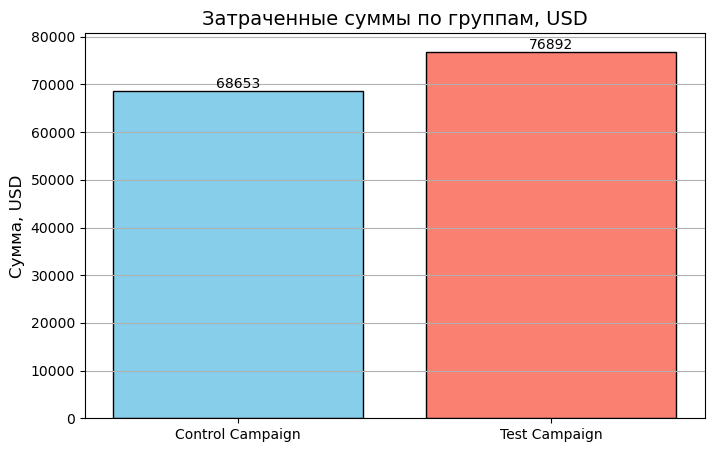

In [27]:
# Подсчет затраченных сумм по группам
control_spend = combined_df[combined_df['campaign_name'] == 'Control Campaign']['spend_usd'].sum()
test_spend = combined_df[combined_df['campaign_name'] == 'Test Campaign']['spend_usd'].sum()


# Расчет процентной разницы
percentage_diff = 100 * abs(control_spend - test_spend) / test_spend
print(f"Разница между группами: {percentage_diff:.2f}%")

# Визуализация
plt.figure(figsize=(8, 5))
bars = plt.bar(['Control Campaign', 'Test Campaign'], [control_spend, test_spend], 
               color=['skyblue', 'salmon'], edgecolor='black')

plt.title('Затраченные суммы по группам, USD', fontsize=14)
plt.ylabel('Сумма, USD', fontsize=12)
plt.grid(axis='y')

# Добавляем подписи значений
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.show()

Рассчитаем среднее значение затраченной суммы на одну покупку по группам и сравним результаты

In [28]:
# Расчет для test группы
avg_sum_test = test_group_df['spend_usd'].sum() / test_group_df['purchase'].sum()

print(f"Средняя стоимость покупки в тестовой группе: ${avg_sum_test:,.2f}")

# Расчет для control группы
avg_sum_control = control_group_df['spend_usd'].sum() / control_group_df['purchase'].sum()

print(f"Средняя стоимость покупки в контрольной группе: ${avg_sum_control:,.2f}")

# Сравнение результатов
if avg_sum_control > 0:
    difference = avg_sum_test - avg_sum_control
    percentage_diff = (difference / avg_sum_control) * 100
    
    print("СРАВНЕНИЕ:")
    print(f"Разница: ${difference:,.2f}")
    print(f"Разница (%) в тестовой относительно контрольной: {percentage_diff:+.2f}%")
    
    if difference < 0:
        print("В тестовой группе ниже средняя стоимость покупки")
    else:
        print("В тестовой группе выше средняя стоимость покупки")

Средняя стоимость покупки в тестовой группе: $4.92
Средняя стоимость покупки в контрольной группе: $4.38
СРАВНЕНИЕ:
Разница: $0.53
Разница (%) в тестовой относительно контрольной: +12.18%
В тестовой группе выше средняя стоимость покупки


<div style="border:solid Chocolate 2px; padding: 10px">
    
По результатам анализа данных, полученных за 30 дней в тестовой и контрольной группе можно сделать следующие выводы:

- Ежедневная динамика пользователей (охвата) и конверсий в покупку отличаются в контрольной и тестовой группах
- Большинство пользователей не переходят на второй этап - переход на сайт. При этом, в тестовой группе доля переходов на сайт выше относительно контрольной группы на 4,3%
- Средняя стоимость покупки в тестовой группе: 4.92 USD. Средняя стоимость покупки в контрольной группе: 4.38 USD. В тестовой группе выше средняя стоимость покупки на 12%

### 3. Оценка корректности проведения теста

- Рассчитаем необходимый размер выборки, сравним с охватом в двух группах.

Разница между группами: 66.26%


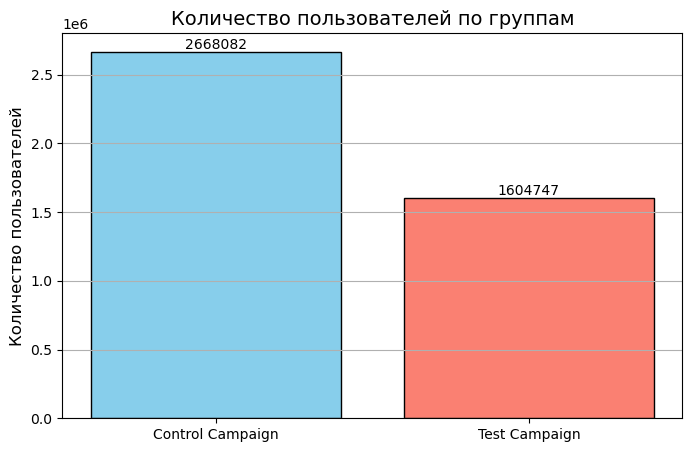

In [29]:
# Рассчитаем фактический объем выборки в контрольной и тестовой группах 
# Подсчет уникальных пользователей по группам
control_users = combined_df[combined_df['campaign_name'] == 'Control Campaign']['reach'].sum()
test_users = combined_df[combined_df['campaign_name'] == 'Test Campaign']['reach'].sum()


# Расчет процентной разницы
percentage_diff = 100 * abs(control_users - test_users) / test_users
print(f"Разница между группами: {percentage_diff:.2f}%")

# Визуализация
plt.figure(figsize=(8, 5))
bars = plt.bar(['Control Campaign', 'Test Campaign'], [control_users, test_users], 
               color=['skyblue', 'salmon'], edgecolor='black')

plt.title('Количество пользователей по группам', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=12)
plt.grid(axis='y')

# Добавляем подписи значений
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.show()

Рассчитаем для каждой группы количество пользователей, сделавших покупку, общее количество пользователей и конверсию

In [30]:
# Считаем покупателей по группам
buyers = combined_df.groupby("campaign_name")['purchase'].sum()

# Считаем охват по группам
all_users = combined_df.groupby("campaign_name")['reach'].sum()

# Рассчитываем конверсию
conversion = (buyers / all_users * 100).round(2)

# Собираем всё в одну таблицу
result = pd.DataFrame({
    "Всего пользователей (охват)": all_users,
    "Сделали покупку": buyers,
    "Конверсия, %": conversion
})

display(result)

,Всего пользователей (охват),Сделали покупку,"Конверсия, %"
campaign_name,,,
Control Campaign,2668082,15662,0.59
Test Campaign,1604747,15637,0.97


Вывод: В тестовой группе (Test Campaign) совершили покупку 1% пользователей, в контрольной группе (Control Campaign) - 0,6% пользователей. Разница 0,4%

In [31]:
# Рассмотрим статистические показатели охвата в контрольной и тестовой выборках
stats_per_group = combined_df.groupby("campaign_name")["reach"].describe()

display(stats_per_group)

,count,mean,std,min,25%,50%,75%,max
campaign_name,,,,,,,,
Control Campaign,30.0,88936.066667,21458.434279,42859.0,75300.25,91579.0,101958.75,127852.0
Test Campaign,30.0,53491.566667,28795.775752,10598.0,31516.25,44219.5,78778.75,109834.0


Можно сделать вывод о том что распределение НЕ имеет нормальную форму т.к. медиана отличается от среднего значения.

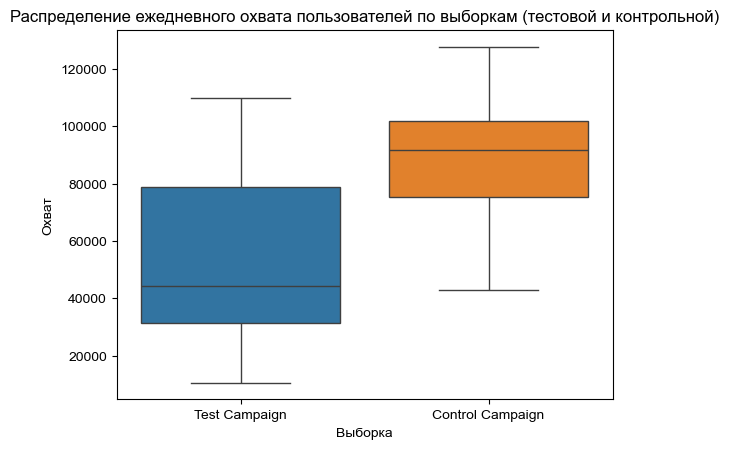

In [32]:
# Сравним распределение охвата по выборкам. Для этого построим boxplot 

sns.boxplot(y='reach', x='campaign_name', data=combined_df, hue="campaign_name", dodge=False)
sns.set(rc={'figure.figsize':(7,5)})
plt.title('Распределение ежедневного охвата пользователей по выборкам (тестовой и контрольной)')
plt.xlabel('Выборка')
plt.ylabel('Охват')
plt.show()

Для определения требуемой выборки установим следующие параметры:

- базовый показатель конверсии — 0,6%,
- мощность теста — 80%,
- достоверность теста — 95%.

In [33]:
# Параметры 
alpha = 0.05        # уровень значимости (95% доверие)
power = 0.80        # мощность теста
p_control = 0.006    # базовая конверсия (control group)
p_test = 0.009       # ожидаемая конверсия (test group) = +0,3 п.п. абсолютного прироста

# Эффект для двух долей
effect_size = proportion_effectsize(p_control, p_test)

# Расчёт требуемого размера выборки (на одну группу)
power_analysis = NormalIndPower()
n_per_group = power_analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    alternative="two-sided",
    ratio=1.0
)

# Округляем вверх
n_per_group = ceil(n_per_group)
n_total = n_per_group * 2

print(f"Необходимый размер выборки на группу: {n_per_group}")
print(f"Итого на тест (control group+test group): {n_total}")

Необходимый размер выборки на группу: 12853
Итого на тест (control group+test group): 25706


Фактический объем выборки обеих групп (более 4,6 млн) значительно превышает требуемый (25 тыс), следовательно, результаты А/Б теста подлежат дальнейшему анализу.

<div style="border:solid Chocolate 2px; padding: 10px">
    
По результатам оценки проведенного теста можно сделать следующие выводы:
- Количество пользователей в контрольной группе превышает тестовую. Разница между группами: 66.26%
- Пользователи в таблицах не пересекаются (дано по условию)
- размер выборки превышает требуемый

Результаты А/Б теста подлежат дальнейшему анализу.

### 4. Проверка результатов А/В теста

- Сформулируем нулевую и альтернативную гипотезы
- Определимся с целевой метрикой.
- Проверим результаты проведенного А/В теста, сделаем выводы.


Формулировка нулевой и альтернативной гипотезы:

**Нулевая гипотеза** - внедрение нового типа торгов "средняя ставка" не повлияло на конверсию

**Альтернативная гипотеза** - внедрение нового типа торгов "средняя ставка" увеличило конверсию в покупки

**Целевая метрика:** конверсия в покупку

Поскольку конверсия в покупку является долевой метрикой, корректно использовать z-тест

In [34]:
n_test, n_control = 1604747, 2668082 # берём значения охвата выборок тестовой группы и контрольной
m_test, m_control = 15637, 15662 # берём значения по количеству покупок в тестовой группы и контрольной

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу 

stat_ztest, p_value_ztest = proportions_ztest(
    [m_control, m_test],
    [n_control, n_test],
    alternative="two-sided"
)
p_value_ztest

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    print(f"Конверсия в тестовой группе = {m_test/n_test:.3%}, в контрольной группе = {m_control/n_control:.3%}")
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
    print(f"Конверсия в тестовой группе = {m_test/n_test:.3%}, в контрольной группе = {m_control/n_control:.3%}")

pvalue=0.0 < 0.05
Нулевая гипотеза не находит подтверждения!
Конверсия в тестовой группе = 0.974%, в контрольной группе = 0.587%


<div style="border:solid Chocolate 2px; padding: 10px">
    
Вывод: По результатам оценки A/B-тестирования можно сделать вывод о том, что внедрение нового типа торгов "средняя ставка" увеличило конверсию в покупки и изменение статистически значимое. Конверсия в тестовой группе = 0.974%, в контрольной группе = 0.587%

### ВЫВОД ПО РЕЗУЛЬТАТАМ ИССЛЕДОВАНИЯ

1. Датасеты control_group.csv и test_group.csv содержат по 10 столбцов и 30 строк по количеству дней проводимого теста, в которых представлена информация о ежедневном количестве и сумме покупок (а также по этапам всей воронки) после увиденной рекламы пользователей контрольной группы (которые НЕ уведомлялись о новом типе торгов) и тестовой группы (которые уведомлялись о новом типе торргов). В ходе ознакомлени и преобразования данных были переименованы столбцы, объединены датасеты, обработаны пропуски, проверены дубликаты.
2. По результатам анализа данных за 30 дней выявлено:

- Ежедневная динамика пользователей (охвата) и конверсий в покупку отличаются в контрольной и тестовой группах
- Большинство пользователей не переходят на второй этап - переход на сайт. При этом, в тестовой группе доля переходов на сайт выше относительно контрольной группы на 4,3%
- Средняя стоимость покупки в тестовой группе: 4.92 USD. Средняя стоимость покупки в контрольной группе: 4.38 USD. В тестовой группе выше средняя стоимость покупки на 12%

3. Размер выборки в контрольной группе превышает тестовую. Выборка является достаточной для проведения А/В теста
4. По результатам оценки A/B-тестирования можно сделать вывод о том, что внедрение нового типа торгов "средняя ставка" увеличило конверсию в покупки и изменение статистически значимое. Конверсия в тестовой группе = 0.974%, в контрольной группе = 0.587%
